![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

# Sequence to Sequence Learning

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

## The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated using the current hidden state and each encoder output, resulting in a vector the same size as the input sequence, called the *attention weights*. These weights are multiplied by the encoder outputs to create a weighted sum of encoder outputs, which is called the *context* vector. The context vector and hidden state are used to predict the next output element.

![](https://i.imgur.com/K1qMPxs.png)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later. The rest are builtin Python libraries.

In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [2]:
USE_CUDA = True

## Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download `fra-eng.zip`, extract the text file in there, and rename it to `data/eng-fra.txt` before continuing (for some reason the zipfile is named backwards). The file is a tab separated list of translation pairs:

```
I am cold.    Je suis froid.
```

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word (`word2count`). This class includes a function `trim(min_count)` to remove rare words once they are all counted.

In [3]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.index_word(word)

### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
#     filename = '../data/%s-%s.txt' % (lang1, lang2)
    filename = '../%s-%s.txt' % (lang1, lang2)
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

The full process for preparing the data is:

* Read text file and split into lines
* Split lines into pairs and normalize
* Filter to pairs of a certain length
* Make word lists from sentences in pairs

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %d sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
    
    print('Indexed %d words in input language, %d words in output' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)

Reading lines...


FileNotFoundError: [Errno 2] No such file or directory: '../eng-fra.txt'

In [8]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'PAD', 1: 'SOS', 2:'EOS', 3:'UNK'}#Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #This line is commented out since it will not properly deal with Chinese Letters
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# def readLangs(lang1, lang2, reverse=False):
#     print("Reading lines...")

#     # Read the file and split into lines
#     lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
#         read().strip().split('\n')

#     # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

#     # Reverse pairs, make Lang instances
#     if reverse:
#         pairs = [list(reversed(p)) for p in pairs]
#         input_lang = Lang(lang2)
#         output_lang = Lang(lang1)
#     else:
#         input_lang = Lang(lang1)
#         output_lang = Lang(lang2)

#     return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

MAX_LENGTH = 100

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


# def filterPair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and \
#         len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(eng_prefixes)
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def readLangs(lang1, lang2, category, reverse = False):#category = ['train', 'dev','test]
    print('Reading lines:')
    lines1 = open('data/iwslt-' + lang1 +'-en/' + category +'.tok.'+ lang1, encoding = 'utf-8').\
    read().strip().split('\n')
    data1 = [normalizeString(l) for l in lines1]
    
    lines2 = open('data/iwslt-' + lang1 +'-en/' + category + '.tok.' + lang2, encoding = 'utf-8').\
    read().strip().split('\n')
    data2 = [normalizeString(l) for l in lines2]
    #Given that data2 is english hence we further normalize
    data2 = [re.sub(r"[^a-zA-Z.!?]+", r" ", data) for data in data2]
    print('Generating pairs')
    pairs = [[data1[i], data2[i]] for i in range(len(data1))]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


In [10]:
#Data Preparation for CHN to ENG
def prepareData(lang1, lang2, category, reverse = False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, category, reverse)
    print('Read %s sentence pairs' % len(pairs))
    pairs = filter_pairs(pairs)
    #Build the vocabulary
    print('Counting words')
    #max_length = 0
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        #Get the maximum legnth 
        #pair_max = max(len(list(filter(None, pair[0].split(' ')))),
          #             len(list(filter(None, pair[1].split(' ')))))
        #max_length = max(pair_max, max_length)
        
    #Test for basic info about the data
    print('Counted Words')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('zh', 'en', 'dev')
print(random.choice(pairs))

Reading lines:
Generating pairs
Read 1261 sentence pairs
Counting words
Counted Words
zh 2874
en 1784
['当 她 从 我们 这里 接过 照片 的 时候    她 跟 我们 分享 了 一些 照片 背后 的 故事', 'when she collected the photos from us she shared a bit of her story with us .']


### Filtering vocabularies

To get something that trains in under an hour, we'll trim the data set a bit. First we will use the `trim` function on each language (defined above) to only include words that are repeated a certain amount of times through the dataset (this softens the difficulty of learning a correct translation for words that don't appear often).

In [11]:
MIN_COUNT = 3

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

keep_words 544 / 2870 = 0.1895
keep_words 440 / 1780 = 0.2472


### Filtering pairs

Now we will go back to the set of all sentence pairs and remove those with unknown words.

In [12]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    
    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break

    for word in output_sentence.split(' '):
        if word not in output_lang.word2index:
            keep_output = False
            break

    # Remove if pair doesn't match input and output conditions
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from %d pairs to %d, %.4f of total" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs

Trimmed from 744 pairs to 45, 0.0605 of total


## Turning training data into Tensors

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a `LongTensor` which represents the index (from the Lang indexes made earlier) of each word. While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

In [13]:
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

We can make better use of the GPU by training on batches of many sequences at once, but doing so brings up the question of how to deal with sequences of varying lengths. The simple solution is to "pad" the shorter sentences with some padding symbol (in this case `0`), and ignore these padded spots when calculating the loss.

![](https://i.imgur.com/gGlkEEF.png)

In [14]:
# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

To create a Variable for a full batch of inputs (and targets) we get a random sample of sequences and pad them all to the length of the longest sequence. We'll keep track of the lengths of each batch in order to un-pad later.

Initializing a `LongTensor` with an array (batches) of arrays (sequences) gives us a `(batch_size x max_len)` tensor - selecting the first dimension gives you a single batch, which is a full sequence. When training the model we'll want a single time step at once, so we'll transpose to `(max_len x batch_size)`. Now selecting along the first dimension returns a single time step across batches.

![](https://i.imgur.com/nBxTG3v.png)

In [15]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

We can test this to see that it will return a `(max_len x batch_size)` tensor for input and target sentences, along with a corresponding list of batch lenghts for each (which we will use for masking later).

In [16]:
random_batch(2)

(tensor([[ 67,  46],
         [350,  41],
         [ 36,   8],
         [  5,  42],
         [439,   2],
         [  5,   0],
         [283,   0],
         [  5,   0],
         [  5,   0],
         [  5,   0],
         [116,   0],
         [  2,   0]], device='cuda:0'), [12, 5], tensor([[251,  23],
         [ 46,  49],
         [ 66,  50],
         [144,  17],
         [ 17,   2],
         [251,   0],
         [ 46,   0],
         [ 17,   0],
         [  2,   0]], device='cuda:0'), [9, 5])

# Building the models

## The Encoder

<img src="images/encoder-network.png" style="float: right" />

The encoder will take a batch of word sequences, a `LongTensor` of size `(max_len x batch_size)`, and output an encoding for each word, a `FloatTensor` of size `(max_len x batch_size x hidden_size)`.

The word inputs are fed through an [embedding layer `nn.Embedding`](http://pytorch.org/docs/nn.html#embedding) to create an embedding for each word, with size `seq_len x hidden_size` (as if it was a batch of words). This is resized to `seq_len x 1 x hidden_size` to fit the expected input of the [GRU layer `nn.GRU`](http://pytorch.org/docs/nn.html#gru). The GRU will return both an output sequence of size `seq_len x hidden_size`.

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

## Attention Decoder

### Interpreting the Bahdanau et al. model

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) (Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio) introduced the idea of using attention for seq2seq translation.

Each decoder output is conditioned on the previous outputs and some $\mathbf x$, where $\mathbf x$ consists of the current hidden state (which takes into account previous outputs) and the attention "context", which is calculated below. The function $g$ is a fully-connected layer with a nonlinear activation, which takes as input the values $y_{i-1}$, $s_i$, and $c_i$ concatenated.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

The current hidden state $s_i$ is calculated by an RNN $f$ with the last hidden state $s_{i-1}$, last decoder output value $y_{i-1}$, and context vector $c_i$.

In the code, the RNN will be a `nn.GRU` layer, the hidden state $s_i$ will be called `hidden`, the output $y_i$ called `output`, and context $c_i$ called `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

The context vector $c_i$ is a weighted sum of all encoder outputs, where each weight $a_{ij}$ is the amount of "attention" paid to the corresponding encoder output $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... where each weight $a_{ij}$ is a normalized (over all steps) attention "energy" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... where each attention energy is calculated with some function $a$ (such as another linear layer) using the last hidden state $s_{i-1}$ and that particular encoder output $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Interpreting the Luong et al. models

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) (Minh-Thang Luong, Hieu Pham, Christopher D. Manning) describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

### Implementing an attention module

In [18]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

### Implementing the Bahdanau et al. model

In summary our decoder should consist of four main parts - an embedding layer turning an input word into a vector; a layer to calculate the attention energy per encoder output; a RNN layer; and an output layer.

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and all encoder outputs $h_*$.

* embedding layer with inputs $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* attention layer $a$ with inputs $(s_{i-1}, h_j)$ and outputs $e_{ij}$, normalized to create $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* context vector $c_i$ as an attention-weighted average of encoder outputs
    * `context = sum(attn_weights * encoder_outputs)`
* RNN layer(s) $f$ with inputs $(s_{i-1}, y_{i-1}, c_i)$ and internal hidden state, outputting $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* an output layer $g$ with inputs $(y_{i-1}, s_i, c_i)$, outputting $y_i$
    * `output = out(embedded, rnn_output, context)`

In [19]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weights, and apply those weights to the encoder outputs to get a context vector.

In [20]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

## Testing the models

To make sure the encoder and decoder modules are working (and working together) we'll do a full test with a small batch.

In [21]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([14, 3])
target_batches torch.Size([21, 3])


Create models with a small size (a good idea for eyeball inspection):

In [22]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(input_lang.n_words, small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, output_lang.n_words, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

To test the encoder, run the input batch through to get per-batch encoder outputs:

In [23]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([14, 3, 8])
encoder_hidden torch.Size([4, 3, 8])


Then starting with a SOS token, run word tokens through the decoder to get each next word token. Instead of doing this with the whole sequence, it is done one at a time, to support using it's own predictions to make the next prediction. This will be one time step at a time, but batched per time step. In order to get this to work for short padded sequences, the batch size is going to get smaller each time.

In [24]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths
)
print('loss', loss.data[0])

/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss tensor(6.0406, device='cuda:0')


/home/yz4499/nlpproject/practical-pytorch/seq2seq-translation/masked_cross_entropy.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_flat = functional.log_softmax(logits_flat)
/home/yz4499/nlpproject/practical-pytorch/seq2seq-translation/masked_cross_entropy.py:9: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  seq_range = torch.range(0, max_len - 1).long()
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing vs. Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [54]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()
        
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for t in range(max_target_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target

    else:
        # Without teacher forcing: use its own predictions as the next input
        for t in range(max_target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            all_decoder_outputs[t] = decoder_output
            if ((decoder_output == EOS_TOKEN).sum().item()) == decoder_output.size(0):#If all are EOS tokens
                break
#             if decoder_input.item() == EOS_token:
#                 break
            
#             decoder_output, decoder_hidden, decoder_attention = batch_decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             decoder_outputs[di] = decoder_input
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.detach()# detach from history as input: size batch x 1 

#             loss += criterion(decoder_output, output_list[:, di])
#             if ((decoder_output == EOS_TOKEN).sum().item()) == decoder_output.size(0):#If all are EOS tokens
#                 break;

#     # Run through decoder one time step at a time
#     for t in range(max_target_length):
#         decoder_output, decoder_hidden, decoder_attn = decoder(
#             decoder_input, decoder_hidden, encoder_outputs
#         )

#         all_decoder_outputs[t] = decoder_output
#         decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0], ec, dc

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, a loss function (criterion), and set up variables for plotting and tracking progress:

In [70]:
# Configure models
attn_model = 'dot'
hidden_size = 500
n_layers = 2
dropout = 0.1
batch_size = 100
batch_size = 16

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.001
decoder_learning_ratio = 5.0
n_epochs = 50000
epoch = 0
plot_every = 5
print_every = 20
evaluate_every = 100

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# import sconce
# job = sconce.Job('seq2seq-translate', {
#     'attn_model': attn_model,
#     'n_layers': n_layers,
#     'dropout': dropout,
#     'hidden_size': hidden_size,
#     'learning_rate': learning_rate,
#     'clip': clip,
#     'teacher_forcing_ratio': teacher_forcing_ratio,
#     'decoder_learning_ratio': decoder_learning_ratio,
# })
# job.plot_every = plot_every
# job.log_every = print_every

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

Plus helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [71]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [85]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq)]
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    
    if USE_CUDA:
        input_batches = input_batches.cuda()
    input_batches, input_lengths, target_batches, target_lengths = random_batch(1)
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [73]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

In [ ]:
import io
import torchvision
from PIL import Image
import visdom
vis = visdom.Visdom()

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

For a better viewing experience we will do the extra work of adding axes and labels:

In [75]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

In [76]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
#     vis.text(text, win=win, opts={'title': win})

# Putting it all together

**TODO** Run `train_epochs` for `n_epochs`

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you're running this notebook you can **train, interrupt, evaluate, and come back to continue training**. Simply run the notebook starting from the following cell (running from the previous cell will reset the models).

In [ ]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    
#     job.record(epoch, loss)

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
#         vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
#         vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


10m 5s (- 4192m 3s) (120 0%) 0.2747
10m 36s (- 3777m 33s) (140 0%) 0.0955
11m 9s (- 3475m 6s) (160 0%) 0.1465
11m 41s (- 3236m 29s) (180 0%) 0.1111


> 但 还有 一些 朝鲜 朝鲜人 就 没 那么 幸运 了
= these north koreans were not so lucky .
< thanks . <EOS>


/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/yz4499/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


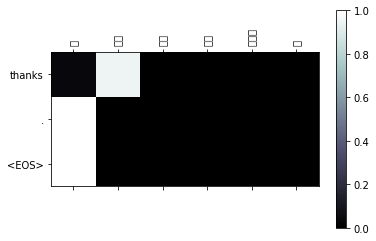

In [86]:
evaluate_randomly()
# output_lang.index2word[8]

## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

<Figure size 432x288 with 0 Axes>

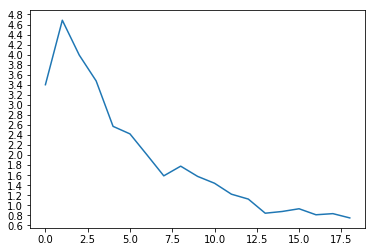

In [61]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [ ]:
output_words, attentions = evaluate("je suis trop froid .")
plt.matshow(attentions.numpy())
# show_plot_visdom()

In [ ]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

In [ ]:
evaluate_and_show_attention("elle est trop petit .")

In [ ]:
evaluate_and_show_attention("je ne crains pas de mourir .")

In [ ]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")

In [ ]:
evaluate_and_show_attention("est le chien vert aujourd hui ?")

In [ ]:
evaluate_and_show_attention("le chat me parle .")

In [ ]:
evaluate_and_show_attention("des centaines de personnes furent arretees ici .")

In [ ]:
evaluate_and_show_attention("des centaines de chiens furent arretees ici .")

In [ ]:
evaluate_and_show_attention("ce fromage est prepare a partir de lait de chevre .")

# Exercises

* Try with a different dataset
    * Another language pair
    * Human &rarr; Machine (e.g. IOT commands)
    * Chat &rarr; Response
    * Question &rarr; Answer
* Replace the embedding pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (`I am test \t I am test`), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there